In [2]:
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler


from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)

/home/teo/dev/narxmodel/narx_darts/venv/lib/python3.10/site-packages/statsforecast/core.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
# Read the CSV file into a DataFrame
# df = pd.read_csv('datasets/simplenarx_dataset.csv', header=None, names=['x1', 'y'])
df = pd.read_csv('datasets/ph_dataset.csv', header=None, names=['x1', 'x2','y'])
# Display the DataFrame
df

,x1,x2,y
0,8.875837,1.000000,6.912909
1,11.025642,1.000000,10.839350
2,9.461355,1.000000,10.894930
3,11.930201,1.000000,10.955416
4,10.890642,1.000000,10.969890
...,...,...,...
1996,12.000000,1.076854,10.948350
1997,12.000000,1.536137,10.979263
1998,12.000000,1.663987,11.017650
1999,12.000000,1.758542,11.003071


In [5]:
# Create the target time series
target_series = TimeSeries.from_dataframe(df, value_cols='y')

# Create the covariate time series
covariate_series = TimeSeries.from_dataframe(df, value_cols=['x1', 'x2'])

<Axes: xlabel='time'>

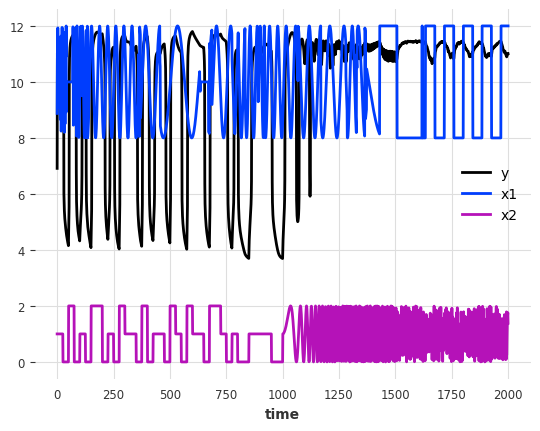

In [6]:
target_series.plot()
covariate_series.plot()

<Axes: xlabel='time'>

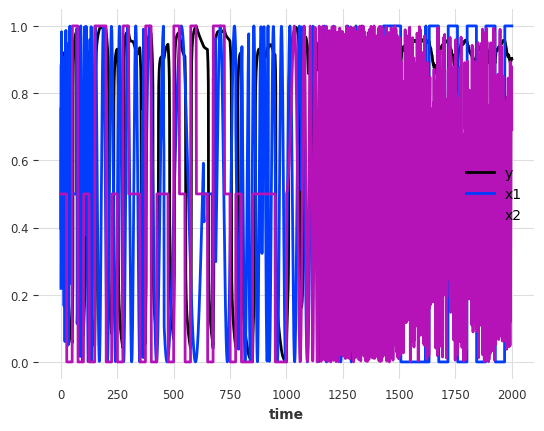

In [7]:
scaler_target, scaler_covariate = Scaler(), Scaler()
target_series_scaled = scaler_target.fit_transform(target_series)
covariate_series_scaled = scaler_covariate.fit_transform(covariate_series)
target_series_scaled.plot()
covariate_series_scaled.plot()

In [8]:
target_series_scaled

<TimeSeries (DataArray) (time: 2001, component: 1, sample: 1)> Size: 16kB
array([[[0.39718779]],

       [[0.88154434]],

       [[0.88840056]],

       ...,

       [[0.90353901]],

       [[0.90174058]],

       [[0.90190119]]])
Coordinates:
  * time       (time) int64 16kB 0 1 2 3 4 5 6 ... 1995 1996 1997 1998 1999 2000
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [81]:
train_target, val_target = target_series_scaled[:1600], target_series_scaled[1600:]
train_covariate, val_covariate = covariate_series_scaled[:1600], covariate_series_scaled[1600:]

In [ ]:
val_covariate

In [91]:
model_name = "RNN_test"
model_futcov = RNNModel(
    model="RNN",
    hidden_dim=10,
    batch_size=8,
    n_epochs=50,
    random_state=0,
    training_length=16,
    input_chunk_length=6,
    model_name=model_name,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    force_reset=True,
)

model_futcov.fit(
    series=train_target,
    future_covariates=train_covariate,
    val_series=val_target,
    val_future_covariates=val_covariate
    )



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 150    | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
161       Trainable params
0         Non-trainable params
161       Total params
0.001     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 198/198 [00:02<00:00, 98.48it/s, train_loss=0.00248, val_loss=0.000376]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 198/198 [00:02<00:00, 98.13it/s, train_loss=0.00248, val_loss=0.000376]


RNNModel(model=RNN, hidden_dim=10, n_rnn_layers=1, dropout=0.0, training_length=16, batch_size=8, n_epochs=50, random_state=0, input_chunk_length=6, model_name=RNN_test, save_checkpoints=True, force_reset=True)

In [92]:
model_futurecov = RNNModel.load_from_checkpoint(model_name=model_name, best=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


<Axes: xlabel='time'>

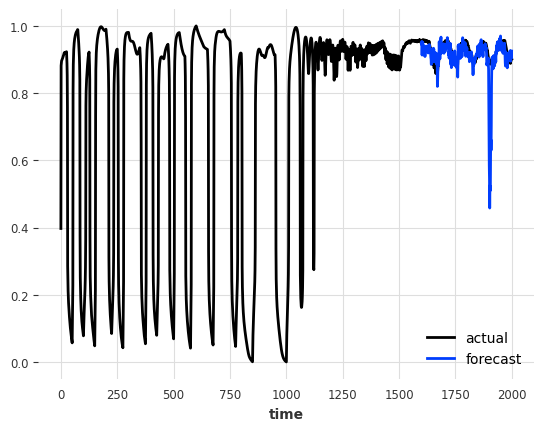

In [93]:
pred_cov = model_futcov.predict(
   n=400,  series=train_target, future_covariates=covariate_series_scaled
)

target_series_scaled.plot(label="actual")
pred_cov.plot(label="forecast")
#plt.legend()

<Axes: xlabel='time'>

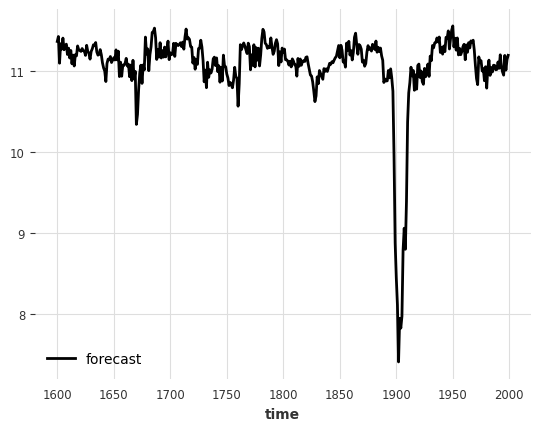

In [100]:
pred_cov_inversed = scaler_target.inverse_transform(pred_cov)
pred_cov_inversed.plot(label="forecast")

In [103]:
model_futurecov.save("model_futurecov")
import joblib
# Assuming 'scaler' is your Scaler instance
joblib.dump(scaler_target, 'scaler_target.save')
joblib.dump(scaler_covariate, 'scaler_covariate.save')

['scaler_covariate.save']